# 1. Pneumonia Classification on chest X-rays

**Pneumonia** is a respiratory infection caused by bacteria or viruses; it affects many individuals, especially in developing and underdeveloped nations, where high levels of pollution, unhygienic living conditions, and overcrowding are relatively common, together with inadequate medical infrastructure. Pneumonia causes pleural effusion, a condition in which fluids fill the lung, causing respiratory difficulty. It accounts for more than **14% of deaths in children** under the age of five years [Ref:WHO](https://www.who.int/news-room/fact-sheets/detail/pneumonia)

Early diagnosis of pneumonia is crucial to ensure curative treatment and increase survival rates. **Chest X-ray imaging** is the most frequently used method for diagnosing pneumonia. However, the examination of chest X-rays is a challenging task and is prone to subjective variability.

Deep learning models using transfer learning can be effectively used for classification of Pneumonia chest X-rays. We will be using Xception model along with fully connected layer added on top. Various fine tuning techniques such as exponential learning rate decay will be used. We will save the best model using callbacks and checkpointing. To avoid overfitting, we will use dropout and augmentation.

- **Dataset:** https://data.mendeley.com/datasets/rscbjbr9sj/2

- Dataset into:
```
    Number of x-ray image classes in train: 2
    ['NORMAL', 'PNEUMONIA']
    NORMAL : 1349
    PNEUMONIA : 3884

    Number of x-ray image classes in test: 2
    ['NORMAL', 'PNEUMONIA']
    NORMAL : 235
    PNEUMONIA : 391

    Class names: ['NORMAL', 'PNEUMONIA']
```

**Notes**:
- A system with GPU will be needed for experimentation and training the models

## 1.1 Obtaining and exploring image data

 - Install - if not already
```
!pip install opencv-contrib-python-headless -Uq
!pip install seaborn -Uq
!pip3 install mlnotify -Uq
```

In [2]:
# Import required libraries

import os
import shutil
from shutil import copy
from shutil import copytree, rmtree
import mlnotify

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

import cv2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img

from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.applications.xception import decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report,confusion_matrix

2023-01-14 21:13:38.333200: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [3]:
print('tf_version:', tf.__version__)
print('device_type:', tf.config.list_physical_devices('GPU'))

tf_version: 2.9.1
device_type: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-01-14 21:13:41.022462: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-14 21:13:41.032257: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-14 21:13:41.032987: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [4]:
# set seed
tf.random.set_seed(1)

### 1.1.1 Data download

In [5]:
# download dataset
!mkdir ./data

!wget --no-check-certificate \
    https://data.mendeley.com/public-files/datasets/rscbjbr9sj/files/f12eaf6d-6023-432f-acc9-80c9d7393433/file_downloaded \
    -O ./data/x-ray.zip



In [6]:
# Extract from archive

!unzip -q ./data/x-ray.zip -d ./data/

In [7]:
# Check the extracted dataset folder
!ls ./data/chest_xray/

test  train


In [8]:
# Cleanup
print('Removing unneeded folders and files...')
! rm -rf ./data/chest_xray/.DS_Store
! rm -rf ./data/chest_xray/train/.DS_Store
! rm -rf ./data/chest_xray/test/.DS_Store
! rm ./data/x-ray.zip
shutil.rmtree('./data/__MACOSX/')

Removing unneeded folders and files...


In [9]:
! ls -l ./data/chest_xray

! ls -l ./data/chest_xray/train

! ls -l ./data/chest_xray/test

total 8
drwxrwsr-x 4 jovyan jovyan 4096 Jan 11 02:39 test
drwxrwsr-x 4 jovyan jovyan 4096 Jan 11 02:39 train
total 284
drwxrwsr-x 2 jovyan jovyan  69632 Dec 31  2017 NORMAL
drwxrwsr-x 2 jovyan jovyan 217088 Jan  6  2018 PNEUMONIA
total 40
drwxrwsr-x 3 jovyan jovyan 16384 Jan 11 02:17 NORMAL
drwxrwsr-x 3 jovyan jovyan 24576 Jan 11 02:18 PNEUMONIA


### 1.1.2 EDA

In [10]:
# Number of images in each class in 'train' and 'test

dataset_dir = './data/chest_xray/'

train_dir = os.path.join(dataset_dir, 'train')
test_dir = os.path.join(dataset_dir, 'test')
class_names = os.listdir(train_dir)

print('Number of x-ray image classes in train:', len(os.listdir(train_dir)))
print(os.listdir(train_dir))
for cls in os.listdir(train_dir):
    print(cls, ':', len(os.listdir(train_dir + '/' + cls)))

print('\nNumber of x-ray image classes in test:', len(os.listdir(test_dir)))
print(os.listdir(test_dir))
for cls in os.listdir(test_dir):
    print(cls, ':', len(os.listdir(test_dir + '/' + cls)))

print('\nClass names:', class_names)

Number of x-ray image classes in train: 2
['NORMAL', 'PNEUMONIA']
NORMAL : 1349
PNEUMONIA : 3884

Number of x-ray image classes in test: 2
['NORMAL', 'PNEUMONIA']
NORMAL : 235
PNEUMONIA : 391

Class names: ['NORMAL', 'PNEUMONIA']


Data in `train_dir` is **imbalanced** - number of images in `PNEUMONIA` is way higher than number of images in `NORMAL`

In [11]:
# let's see what the filenames look like
print(os.listdir(train_dir + '/' + 'NORMAL')[:5])
print(os.listdir(train_dir + '/' + 'PNEUMONIA')[:5])

['NORMAL2-IM-0517-0001.jpeg', 'IM-0305-0001.jpeg', 'IM-0674-0001.jpeg', 'NORMAL2-IM-0634-0001.jpeg', 'IM-0215-0001.jpeg']
['person1265_virus_2156.jpeg', 'person625_virus_1199.jpeg', 'person737_bacteria_2640.jpeg', 'person325_bacteria_1497.jpeg', 'person1523_bacteria_3979.jpeg']


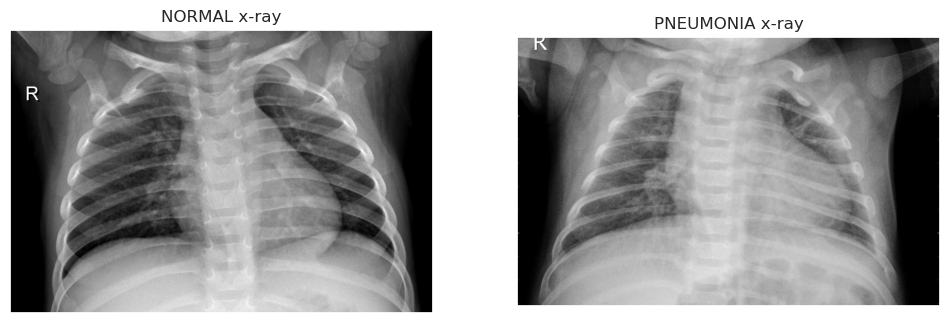

In [12]:
# Visualize one image from each class - ['NORMAL', 'PNEUMONIA']
npic = './data/chest_xray/train/NORMAL/NORMAL2-IM-0517-0001.jpeg'
ppic = './data/chest_xray/train/PNEUMONIA/person1265_virus_2156.jpeg'

plt.figure(1, figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(cv2.imread(npic))
plt.title("NORMAL x-ray")
plt.xticks([]) , plt.yticks([])

plt.subplot(1, 2, 2)
plt.imshow(cv2.imread(ppic))
plt.title("PNEUMONIA x-ray")
plt.xticks([]) , plt.yticks([])

plt.show()

## 1.2 Correct for data imbalance

- Let's correct class imbalance by using class weighting
- Set the weight for class 0 (Normal) a lot higher than the weight for class 1 (Pneumonia). Because there are less normal images, each normal image will be weighted more to balance the data as the CNN works best when the training data is balanced.

In [13]:
COUNT_NORMAL = 1349
COUNT_PNEUMONIA = 3884

initial_bias = np.log([COUNT_PNEUMONIA / COUNT_NORMAL])
print("Initial bias: {:.5f}".format(initial_bias[0]))

TRAIN_IMG_COUNT = COUNT_NORMAL + COUNT_PNEUMONIA
weight_for_0 = (1 / COUNT_NORMAL) * (TRAIN_IMG_COUNT) / 2.0
weight_for_1 = (1 / COUNT_PNEUMONIA) * (TRAIN_IMG_COUNT) / 2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print("Weight for class 0: {:.2f}".format(weight_for_0))
print("Weight for class 1: {:.2f}".format(weight_for_1))

Initial bias: 1.05750
Weight for class 0: 1.94
Weight for class 1: 0.67


## 1.3 Data preprocessing

In [14]:
# Parameters

input_size = 299
batch_size = 32
learning_rate = 0.0005
size_inner = 128
droprate = 0.2
n_epochs = 20

In [15]:
# data generatores

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    shear_range=10,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.2     # set validation split
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

# Flow training images in batches using train_datagen generator
train_ds = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(input_size, input_size),  # All images will be resized
        batch_size=batch_size,
        subset='training'      # set as training data
)

# Flow val images in batches using val_datagen generator
val_ds = train_datagen.flow_from_directory(
        train_dir,  # same directory as training data
        target_size=(input_size, input_size),  # All images will be resized
        batch_size=batch_size,
        subset='validation'     # set as validation data
)

# Flow test images in batches using test_datagen generator
test_ds = test_datagen.flow_from_directory(
        test_dir,  # This is the source directory for test images
        target_size=(input_size, input_size),  # All images will be resized
        batch_size=batch_size,
        shuffle=False
)

Found 4187 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.
Found 629 images belonging to 2 classes.


In [16]:
# Let's look at 1 of the the batches
train_batch = train_ds[0]
images, labels = list(train_batch)
print(images.shape)
print(labels.shape)

first_image = images[0]
first_image

(32, 299, 299, 3)
(32, 2)


array([[[-0.8094895 , -0.8094895 , -0.8094895 ],
        [-0.73024935, -0.73024935, -0.73024935],
        [-0.6070577 , -0.6070577 , -0.6070577 ],
        ...,
        [ 0.01082194,  0.01082194,  0.01082194],
        [ 0.01082194,  0.01082194,  0.01082194],
        [ 0.01082194,  0.01082194,  0.01082194]],

       [[-0.83429855, -0.83429855, -0.83429855],
        [-0.7605554 , -0.7605554 , -0.7605554 ],
        [-0.6282015 , -0.6282015 , -0.6282015 ],
        ...,
        [-0.02701724, -0.02701724, -0.02701724],
        [-0.02701724, -0.02701724, -0.02701724],
        [-0.02701724, -0.02701724, -0.02701724]],

       [[-0.8297581 , -0.8297581 , -0.8297581 ],
        [-0.78322875, -0.78322875, -0.78322875],
        [-0.64047456, -0.64047456, -0.64047456],
        ...,
        [-0.00108296, -0.00108296, -0.00108296],
        [-0.00108296, -0.00108296, -0.00108296],
        [-0.00108296, -0.00108296, -0.00108296]],

       ...,

       [[-1.        , -1.        , -1.        ],
        [-1

In [17]:
first_image[:3, :3, 0]

array([[-0.8094895 , -0.73024935, -0.6070577 ],
       [-0.83429855, -0.7605554 , -0.6282015 ],
       [-0.8297581 , -0.78322875, -0.64047456]], dtype=float32)

## 1.4 Build model

We will be using pre-trained convolutional neural network model known as `Xception`.

Pre-trained convolutional neural networks:

- Imagenet dataset: https://www.image-net.org/
- Pre-trained models: https://keras.io/api/applications/

Other models for consideration:
- InceptionV3
- ResNet50
- DenseNet121

In [18]:
def make_model(input_size=299, learning_rate=0.001, size_inner=512,
               droprate=0.2):

    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(input_size, input_size, 3)
    )

    base_model.trainable = False

    #########################################

    inputs = keras.Input(shape=(input_size, input_size, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    
    inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
    drop = keras.layers.Dropout(droprate)(inner)
    
    outputs = keras.layers.Dense(2)(drop)
    
    model = keras.Model(inputs, outputs)
    
    #########################################

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)
 
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    
    return model

### 1.4.1 finetuning steps

- Checkpint and early stopping callbacks
- Finetune model with exponential learning rate decay

#### Defining callbacks

In [19]:
# Checkpoint callback
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "xray_model.h5",
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

# Defining early stopping to prevent overfitting
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    mode = 'auto',
    min_delta = 0,
    patience = 2,
    verbose = 2,
    restore_best_weights = True
)

#### Exponential learning rate decay 

In [20]:
# Exponential learning rate decay
initial_learning_rate = 0.015
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)

#### Build model 

In [21]:
model = make_model(
    input_size=input_size,
    learning_rate=lr_schedule,
    size_inner=size_inner,
    droprate=droprate
)

2023-01-14 21:13:46.017826: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-14 21:13:46.018269: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-14 21:13:46.018975: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-14 21:13:46.019530: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so ret

In [22]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                             

## 1.5 Training, Evaluation and prediction

Let's fit the model now

### 1.5.1 Fit the model

In [23]:
history = model.fit(
    train_ds,
    # steps_per_epoch=130,  # Total train images = batch_size * steps
    epochs=n_epochs,
    validation_data=val_ds,
    # validation_steps=32,  # Total val images = batch_size * steps
    class_weight=class_weight,
    verbose=2,
    callbacks=[checkpoint_cb, early_stopping_cb]
)

                                     
                                     
    █▀▀▀▀▀█  ▀▀█▄▄█ █▀█ ▄ █▀▀▀▀▀█    
    █ ███ █ ▄▀██ ▄█ █▄▄▄▄ █ ███ █    
    █ ▀▀▀ █ ▀▄█ ▀▄▀ ▀█▀▀▀ █ ▀▀▀ █    
    ▀▀▀▀▀▀▀ ▀▄▀ █ █▄█ █▄▀ ▀▀▀▀▀▀▀    
    ██▄▄▄▀▀█ ▀█ ▀█ ▄ ▀▄▄▀▄ ▄█▀▄▄     
    ▄▀ ▀▄█▀▄▄▀▄█▀  ▀▀▀▀▄█  █ ▄       
    ▀▀▀█▄ ▀▄▄▀█ ▄ █▄█▄▄▄█ ██▄  ▄█    
      ▄▀▀▄▀▀▀ ▄ ▄ ██ ▀  ▄██▄ ▀█ ▄    
    ▄   ▀█▀█▄▀▄ ▀█▄▄▄█▄▄█ ▄▄▄▀█▄▄    
    █▀█ ██▀▄▄ ▀▄▀▀█▀ ▀ ▀  ██▀▀  ▀    
    ▀ ▀▀▀▀▀▀█▀▀▀▄▀ ▄ ██ █▀▀▀█▄▀▀▀    
    █▀▀▀▀▀█ █   ▄▀█▀▀▀ ██ ▀ █▀▀▄▄    
    █ ███ █  ▀▄▀▀ ███  ▀██▀▀▀█▄▀▄    
    █ ▀▀▀ █ ▄█▄█▀  █▄ ▄▀▀ ▀████▀▄    
    ▀▀▀▀▀▀▀ ▀ ▀▀▀  ▀▀▀     ▀  ▀      
                                     
                                     
https://mlnotify.aporia.com/training/384971

Scan the QR code or enter the url to get a notification when your training is done


Epoch 1/20


2023-01-14 21:13:54.687034: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2023-01-14 21:13:55.338967: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-01-14 21:13:55.339767: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-01-14 21:13:55.339806: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-01-14 21:13:55.340449: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-01-14 21:13:55.340533: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


131/131 - 137s - loss: 0.3412 - accuracy: 0.9037 - val_loss: 0.1562 - val_accuracy: 0.9330 - 137s/epoch - 1s/step
Epoch 2/20
131/131 - 133s - loss: 0.1590 - accuracy: 0.9369 - val_loss: 0.1127 - val_accuracy: 0.9589 - 133s/epoch - 1s/step
Epoch 3/20
131/131 - 133s - loss: 0.1737 - accuracy: 0.9355 - val_loss: 0.1942 - val_accuracy: 0.9263 - 133s/epoch - 1s/step
Epoch 4/20
Restoring model weights from the end of the best epoch: 2.
131/131 - 134s - loss: 0.1458 - accuracy: 0.9422 - val_loss: 0.1384 - val_accuracy: 0.9598 - 134s/epoch - 1s/step
Epoch 4: early stopping


### 1.5.2 Visualizing model performance

Let's plot the model accuracy and loss for the training and the validating set.

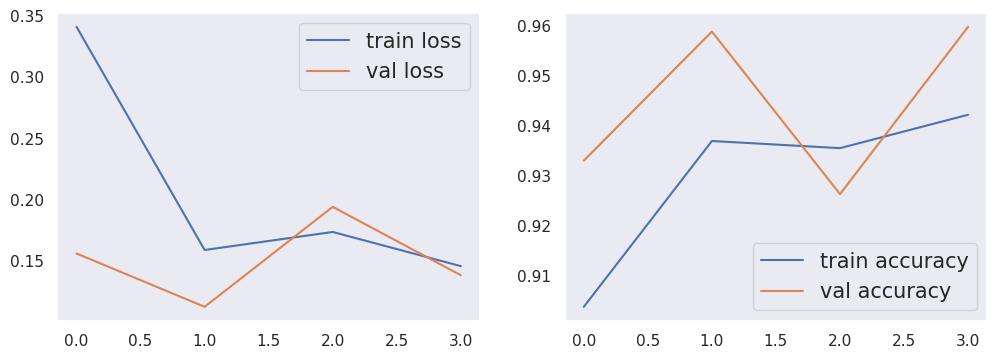

In [24]:
# plot loss and accuracy

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.grid()
plt.legend(fontsize=15)

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.grid()
plt.legend(fontsize=15)

### 1.5.3 Evaluate model

In [25]:
# evaluate on val data
model.evaluate(val_ds, verbose=2, return_dict=True)

33/33 - 27s - loss: 0.1288 - accuracy: 0.9522 - 27s/epoch - 804ms/step


{'loss': 0.12882697582244873, 'accuracy': 0.9521530866622925}

### 1.5.4 Predict on test data

In [26]:
# predict on test data
test_ds.reset()
preds = model.predict(test_ds, verbose=2)
# preds
preds.shape

20/20 - 7s - 7s/epoch - 347ms/step


(629, 2)

In [27]:
preds[155]

array([ 1.0675673, -2.742319 ], dtype=float32)

In [28]:
preds[555]

array([-3.1739776,  4.6959805], dtype=float32)

In [29]:
classes = train_ds.class_indices
classes

{'NORMAL': 0, 'PNEUMONIA': 1}

In [30]:
class_names = ['NORMAL', 'PNEUMONIA']

In [31]:
dict(zip(class_names, preds[600]))

{'NORMAL': -5.9625845, 'PNEUMONIA': 7.5589848}

In [32]:
predicted_class_indices=np.argmax(preds,axis=1)
labels = (train_ds.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]
# predictions


### 1.5.5 Save predictions in DataFrame and to csv file

In [33]:
filenames=test_ds.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})

results[:-3]

,Filename,Predictions
0,NORMAL/IM-0001-0001.jpeg,NORMAL
1,NORMAL/IM-0003-0001.jpeg,NORMAL
2,NORMAL/IM-0005-0001.jpeg,NORMAL
3,NORMAL/IM-0006-0001.jpeg,NORMAL
4,NORMAL/IM-0007-0001.jpeg,NORMAL
...,...,...
621,PNEUMONIA/person96_bacteria_465.jpeg,PNEUMONIA
622,PNEUMONIA/person96_bacteria_466.jpeg,PNEUMONIA
623,PNEUMONIA/person97_bacteria_468.jpeg,PNEUMONIA
624,PNEUMONIA/person99_bacteria_473.jpeg,PNEUMONIA


In [34]:
# save results to csv file
results.to_csv('filename_predictions.csv')

In [35]:
# Check few random predictions

results.sample(10).reset_index()

,index,Filename,Predictions
0,45,NORMAL/IM-0073-0001.jpeg,PNEUMONIA
1,47,NORMAL/IM-0077-0001.jpeg,NORMAL
2,600,PNEUMONIA/person88_bacteria_438.jpeg,PNEUMONIA
3,589,PNEUMONIA/person85_bacteria_417.jpeg,PNEUMONIA
4,244,PNEUMONIA/person101_bacteria_484.jpeg,PNEUMONIA
5,523,PNEUMONIA/person41_virus_88.jpeg,PNEUMONIA
6,434,PNEUMONIA/person1637_virus_2834.jpeg,PNEUMONIA
7,328,PNEUMONIA/person130_bacteria_628.jpeg,PNEUMONIA
8,17,NORMAL/IM-0023-0001.jpeg,NORMAL
9,580,PNEUMONIA/person82_bacteria_403.jpeg,PNEUMONIA


### 1.5.6 classification report and confusion matrix

In [36]:
# classification report
actual = test_ds.classes
print(classification_report(predicted_class_indices, actual))

              precision    recall  f1-score   support

           0       0.72      0.93      0.82       183
           1       0.97      0.85      0.91       446

    accuracy                           0.88       629
   macro avg       0.85      0.89      0.86       629
weighted avg       0.90      0.88      0.88       629



In [37]:
confusion_matrix(actual, predicted_class_indices)

array([[171,  65],
       [ 12, 381]])

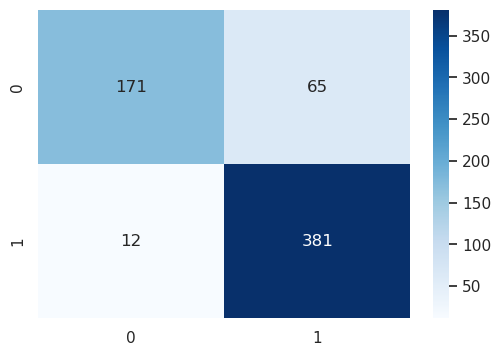

In [38]:
# Confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(actual, predicted_class_indices), annot = True, fmt = 'd', cmap = 'Blues');

### 1.5.7 Test individual images

In [39]:
path = './data/chest_xray/test/NORMAL/IM-0105-0001.jpeg'

img = load_img(path, target_size=(299, 299))
img

x = tf.keras.preprocessing.image.img_to_array(img)
X = np.array([x])  # Convert single image to a batch.
X.shape

X = preprocess_input(X)
pred = model.predict(X, verbose=2)

dict(zip(classes, pred[0]))

1/1 - 1s - 841ms/epoch - 841ms/step


{'NORMAL': 2.196762, 'PNEUMONIA': -5.5115433}

In [40]:
path = './data/chest_xray/test/PNEUMONIA/person104_bacteria_492.jpeg'

img = load_img(path, target_size=(299, 299))
img

x = tf.keras.preprocessing.image.img_to_array(img)
X = np.array([x])  # Convert single image to a batch.
X.shape

X = preprocess_input(X)
pred = model.predict(X, verbose=2)

dict(zip(classes, pred[0]))

1/1 - 0s - 20ms/epoch - 20ms/step


{'NORMAL': -7.2323003, 'PNEUMONIA': 10.508498}

## 1.6 Using the model

- Loading the model
- Evaluating the model
- Getting predictions

In [1]:
import numpy as np

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img

from tensorflow.keras.applications.xception import preprocess_input

2023-01-16 02:41:42.638112: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [42]:
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_ds = test_datagen.flow_from_directory(
    test_dir,
    target_size=(299, 299),
    batch_size=32,
    shuffle=False
)

Found 629 images belonging to 2 classes.


In [ ]:
model = keras.models.load_model('xray_model.h5')

In [ ]:
model.evaluate(test_ds)

In [4]:
path = './data/chest_xray/test/PNEUMONIA/person104_bacteria_492.jpeg'

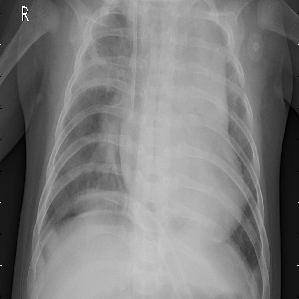

In [5]:
img = load_img(path, target_size=(299, 299))
img

In [6]:
x = np.array(img)
X = np.array([x])
X.shape

(1, 299, 299, 3)

In [7]:
X = preprocess_input(X)

In [ ]:
pred = model.predict(X)

In [50]:
classes = test_ds.class_indices
classes

{'NORMAL': 0, 'PNEUMONIA': 1}

In [51]:
class_names = ['NORMAL', 'PNEUMONIA']

In [52]:
dict(zip(classes, pred[0]))

{'NORMAL': -14.510404, 'PNEUMONIA': 11.681322}